In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter
import chardet
from scipy.stats import pearsonr

from seaborn import violinplot
from seaborn import boxplot
from seaborn import displot

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from boruta import BorutaPy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

# **Descrição do Projeto**
A base de dados encontra-se disponível no seguinte desafio do [Kaggle](https://www.kaggle.com/competitions/santander-customer-satisfaction/data).
<ul>
<li><u>O projeto consiste em criar um modelo de classificação para prever satisfação de clientes</u>;</li>
<li>Os dados estão aleatorizados e contém uma série de colunas numéricas; </li> 
<li>A variável 'target' é a que deve ser prevista. 'TARGET' = 0 satisfeito | 'TARGET' = 1 insatisfeito;</li>
<li>A classificação é necessária a fim de fazer uma ação de <b><i><span style="color:red">retenção de clientes</span></b></i>.</li>
</ul>

---
Classificações:
|Classificação|Y_teste|Y_predito|Custo Ação|Lucro Ação|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|TP    |1     |1     |-3     |150     |
|FP     |0     |1     |-3     |0     |
|TN     |0     |0     |0     |0     |
|FN     |1     |0     |0     |0     |

In [2]:
#Determinar encoding do CSV que será utilizado no projeto.
rawdata=open('/Users/Alvaro/Documents/Coderhouse/Projeto/data.csv', 'rb').read()
chardet.detect(rawdata)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [3]:
#Data Acquisition.
df = pd.read_csv('/Users/Alvaro/Documents/Coderhouse/Projeto/data.csv',delimiter=',',encoding='ascii')
df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


##### EDA

In [4]:
#EDA
df.info()
#Todas as 371 colunas são numéricas. Não há variáveis com formato de texto.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
#EDA
nulos=df.isnull().sum().sum()
print(f'qtd de nulos: {nulos}')
duplicados = df.duplicated().sum()
print(f'qtd de duplicados: {duplicados}')
qualitativas = [column for column in df if df[column].dtype.name == 'object']
print(f'qtd de colunas qualitativas: {len(qualitativas)}')
um_valor = [column for column in df if df[column].nunique() < 2]
print(f'qtd de colunas com apenas um valor: {len(um_valor)}')
binárias = [column for column in df if df[column].nunique() == 2]
print(f'qtd de colunas binárias: {len(binárias)}')
nao_binarias = [column for column in df if df[column].nunique() > 2]
print(f'qtd de colunas não binárias: {len(nao_binarias)}')
#Não há nenhum nulo ou duplicado. 
#Não há nenhuma coluna qualitativa.
#Há 34 colunas com um único valor, estas colunas não são úteis para modelagem.

qtd de nulos: 0
qtd de duplicados: 0
qtd de colunas qualitativas: 0
qtd de colunas com apenas um valor: 34
qtd de colunas binárias: 106
qtd de colunas não binárias: 231


In [6]:
#EDA
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.960431
1    0.039569
Name: proportion, dtype: float64

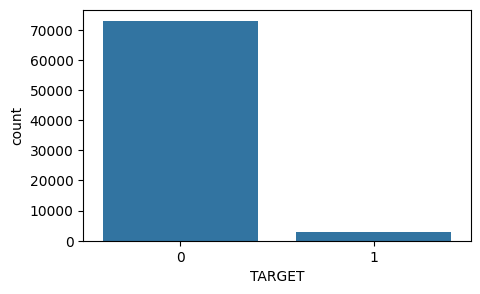

In [7]:
#EDA
plt.figure(figsize=(5,3))
sns.countplot(x = 'TARGET', data = df)
plt.show()
#Target está bastante desbalanceada. Na hora que for dividir em treino e teste, será necessário estratificar

In [25]:
#EDA
#Análise de outliers. 
#Para cada coluna não binária, foi feita a análise e descartadas as linhas referentes a outliers.
#for key in df.columns.values.tolist():
#  if key in nao_binarias:
#    print(key)
#    Q1 = df[key].quantile(0.25)
#    Q3 = df[key].quantile(0.75)
#    IIQ = Q3 - Q1 
#    filter = (df[key] >= Q1 - 1.5 * IIQ) & (df[key] <= Q3 + 1.5 *IIQ)
#    df = df.loc[filter]
#  else:
#    print('falso')
#df.info()
#A análise apontou que das 76k linhas, apenas 15k seriam mantidas. Todas as TARGET = 1 seriam perdidas.
#Dessa forma, não foram descartadas as linhas referentes a outliers.

##### Pré processamento
O dataset tem muitas variáveis, portanto será utilizado o algoritmo 'boruta' para determinar as principais features.

In [8]:
#Pré processamento. Separar a target das features.
X = df.drop(['TARGET'],axis=1)    #Independentes
y = df['TARGET'] #Target

In [9]:
#Pré processamento. Necessário estratificar pq a target está desbalanceada
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y,test_size = 0.3, random_state = 42)

In [10]:
#Pré processamento. Chamando o RandomForest
rf = RandomForestClassifier(max_depth = 5, bootstrap = True)

In [11]:
#Pré processamento. Para conseguir utilizar o Boruta, foi necessário tratar o formato das colunas do numpy
np.int = np.int32
np.float = np.float64
np.bool = np.bool_
feat_selector = BorutaPy(rf, n_estimators = "auto", random_state = 999)

In [12]:
#Pré processamento. Treinando o Boruta.
result_boruta = feat_selector.fit(X_train.values, y_train)

In [13]:
#Pré processamento. o Boruta entregou uma lista de 37 variáveis que apresentaram ranking de importância máximo.
accept = X_train.columns[feat_selector.support_].to_list()
#feat_selector.ranking_ entega o ranking de cada uma das features

print(f"Qtd de features selecionadas: {len(accept)}")
print("Selecionadas:")
print(accept)

Qtd de features selecionadas: 37
Selecionadas:
['var15', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var4', 'num_var5', 'num_var8_0', 'num_var30_0', 'num_var30', 'num_var35', 'num_var42', 'saldo_var5', 'saldo_var8', 'saldo_var30', 'saldo_var42', 'var36', 'num_var22_ult1', 'num_var22_ult3', 'num_med_var22_ult3', 'num_meses_var5_ult3', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1', 'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'var38']


In [14]:
#Pré processamento. É criado um novo dataframe com apenas as 37 colunas que serão utilizadas.
df_final = df[['var15','imp_op_var40_efect_ult1','imp_op_var40_efect_ult3','imp_op_var41_efect_ult1','imp_op_var41_efect_ult3','imp_op_var41_ult1',
'imp_op_var39_efect_ult1','imp_op_var39_efect_ult3','imp_op_var39_ult1','ind_var5','ind_var8_0','ind_var30','num_var4','num_var5',
'num_var8_0', 'num_var30_0', 'num_var30', 'num_var35', 'num_var42', 'saldo_var5', 'saldo_var8', 'saldo_var30', 'saldo_var42', 'var36',
'num_var22_ult1', 'num_var22_ult3', 'num_med_var22_ult3', 'num_meses_var5_ult3', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1',
'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'var38', 'TARGET']]
df_final
#df_final será a base utilizada no treinamento dos modelos

,var15,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,ind_var5,...,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38,TARGET
0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.00,0.00,0.00,0.00,39205.170000,0
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.00,88.89,0.00,0.00,49278.030000,0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,3.00,0.18,3.00,2.07,67333.770000,0
3,37,0.0,0.0,0.0,0.0,195.0,0.0,0.0,195.0,1,...,27,3,18,48,186.09,0.00,91.56,138.84,64007.970000,0
4,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,3.00,0.30,40501.08,13501.47,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.00,0.00,0.00,0.00,60926.490000,0
76016,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,36,3,9,48,130.65,0.00,0.00,0.00,118634.520000,0
76017,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,3.00,0.00,3.00,3.00,74028.150000,0
76018,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,3.00,1.74,3.00,2.58,84278.160000,0


##### Modelagem
Trata-se de um problema de classificação binário. Serão testados três algoritmos: RandomForest, Reg Logística e XGBOOST\
O modelo que tiver os melhores indicadores de desempenho após a otimização será o escolhido.

In [15]:
X = df_final.drop(['TARGET'],axis=1)    #Independentes
y = df_final['TARGET'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y,test_size = 0.3, random_state = 42)

In [16]:
#Modelagem. Primeiro modelo testado será o RandomForest
dict_weights = {0:0.520599, 1: 12.6363}
#Observações totais / (número de classes * observações da classe). Classe 0 tem peso 0,52 e classe 1 tem peso 12,63
rf = RandomForestClassifier(max_depth=4,random_state=42, class_weight=dict_weights).fit(X_train, y_train)

In [17]:
#Modelagem. RandomForest
y_test_pred_RF = rf.predict(X_test) #Predict no teste
y_treino_pred_RF = rf.predict(X_train) #Predict no treino

[[16776  5128]
 [  279   623]]


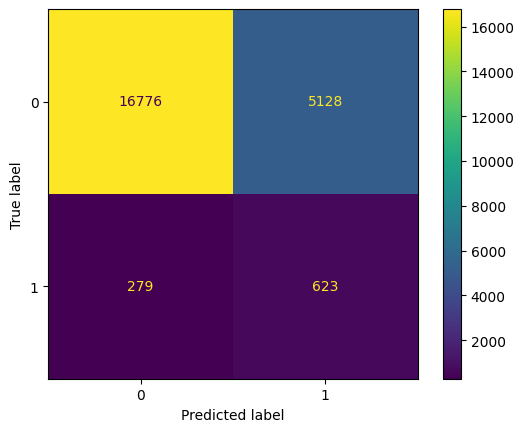

In [18]:
#Modelagem. RandomForest matriz de confusão
cm = confusion_matrix(y_test, y_test_pred_RF)
print(confusion_matrix(y_test, y_test_pred_RF))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [19]:
#Modelagem. RandomForest indicadores de desempenho
# Acurácia
acur = accuracy_score(y_test, y_test_pred_RF)
print(f"Accuracy of the classifier is: {acur}")
# Precisão!
prec = precision_score(y_test, y_test_pred_RF)
print(f"Precisão: {prec}")
#Recall!
rec = recall_score(y_test, y_test_pred_RF)
print(f"Recall: {rec}")
#F1_Score!
f1 = f1_score(y_test, y_test_pred_RF)
print(f"F1 Score: {f1}")
#KS V2
def ks_v2 (y_true,y_pred_proba):
    pos_preds__pos=y_pred_proba[y_true==1]
    neg_preds__pos=y_pred_proba[y_true==0]
    return ks_2samp(pos_preds__pos,neg_preds__pos)[0]
ks_treino = ks_v2(y_train,y_treino_pred_RF)
ks_teste = ks_v2(y_test,y_test_pred_RF)
delta = ks_treino - ks_teste
print('ks_treino, {}\nks_teste {}\n,delta{}'.format(ks_treino,ks_teste,delta))

Accuracy of the classifier is: 0.7629132684381303
Precisão: 0.10832898626325857
Recall: 0.6906873614190687
F1 Score: 0.1872839320607245
ks_treino, 0.47008602753300255
ks_teste 0.45657487054982104
,delta0.013511156983181505


In [20]:
#Modelagem. Segundo modelo testado será a Regressão Logística
dict_weights = {0:0.520599, 1: 12.6363}
#Observações totais / (número de classes * observações da classe). Classe 0 tem peso 0,52 e classe 1 tem peso 12,63
reg_logistica = LogisticRegression(random_state=42,class_weight=dict_weights,max_iter=3000).fit(X_train, y_train)

c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
#Modelagem. Regressão Logística
y_test_pred_RL = reg_logistica.predict(X_test)
y_treino_pred_RL = reg_logistica.predict(X_train)

[[14448  7456]
 [  227   675]]


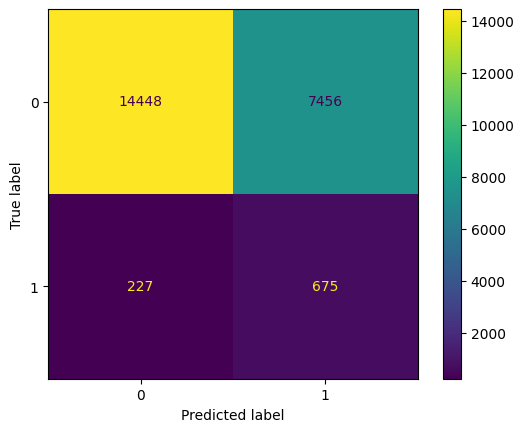

In [22]:
#Modelagem. Regressão Logística matriz de confusão
cm = confusion_matrix(y_test, y_test_pred_RL)
print(confusion_matrix(y_test, y_test_pred_RL))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
#Modelagem. Regressão Logística indicadores de desempenho
# Acurácia
acur = accuracy_score(y_test, y_test_pred_RL)
print(f"Accuracy of the classifier is: {acur}")
# Precisão!
prec = precision_score(y_test, y_test_pred_RL)
print(f"Precisão: {prec}")
#Recall!
rec = recall_score(y_test, y_test_pred_RL)
print(f"Recall: {rec}")
#F1_Score!
f1 = f1_score(y_test, y_test_pred_RL)
print(f"F1 Score: {f1}")
#KS V2
def ks_v2 (y_true,y_pred_proba):
    pos_preds__pos=y_pred_proba[y_true==1]
    neg_preds__pos=y_pred_proba[y_true==0]
    return ks_2samp(pos_preds__pos,neg_preds__pos)[0]
ks_treino = ks_v2(y_train,y_treino_pred_RL)
ks_teste = ks_v2(y_test,y_test_pred_RL)
delta = ks_treino - ks_teste
print('ks_treino, {}\nks_teste {}\n,delta{}'.format(ks_treino,ks_teste,delta))

Accuracy of the classifier is: 0.663114969744804
Precisão: 0.08301561923502644
Recall: 0.7483370288248337
F1 Score: 0.14945200929923613
ks_treino, 0.4071481385600506
ks_teste 0.4079425803222771
,delta-0.0007944417622264832


In [24]:
#Modelagem. Terceiro modelo testado será o XGBOOST
#scale_pos_weight = negativos / positivos (qtd de linhas da classe 0 dividido pela qtd de linhas da classe 1)
xgboost_clf = xgb.XGBClassifier(scale_pos_weight=24.28,eta=0.1,seed=42).fit(X_train, y_train)

In [25]:
#Modelagem. XGBOOST
y_test_pred_XG = xgboost_clf.predict(X_test)
y_treino_pred_XG = xgboost_clf.predict(X_train)

[[17845  4059]
 [  270   632]]


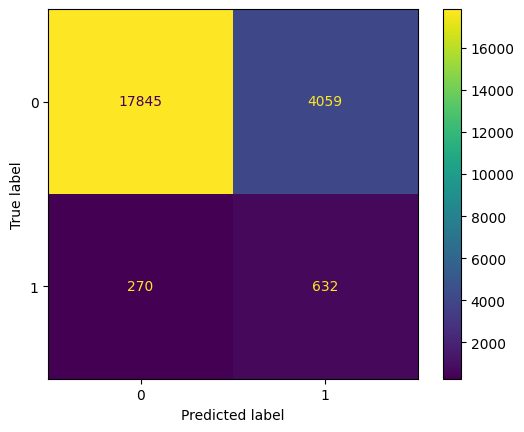

In [26]:
#Modelagem. XGBOOST matriz de confusão
cm = confusion_matrix(y_test, y_test_pred_XG)
print(confusion_matrix(y_test, y_test_pred_XG))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [27]:
#Modelagem. XGBOOST indicadores de desempenho
# Acurácia
acur = accuracy_score(y_test, y_test_pred_XG)
print(f"Accuracy of the classifier is: {acur}")
# Precisão!
prec = precision_score(y_test, y_test_pred_XG)
print(f"Precisão: {prec}")
#Recall!
rec = recall_score(y_test, y_test_pred_XG)
print(f"Recall: {rec}")
#F1_Score!
f1 = f1_score(y_test, y_test_pred_XG)
print(f"F1 Score: {f1}")
#KS V2
def ks_v2 (y_true,y_pred_proba):
    pos_preds__pos=y_pred_proba[y_true==1]
    neg_preds__pos=y_pred_proba[y_true==0]
    return ks_2samp(pos_preds__pos,neg_preds__pos)[0]
ks_treino = ks_v2(y_train,y_treino_pred_XG)
ks_teste = ks_v2(y_test,y_test_pred_XG)
delta = ks_treino - ks_teste
print('ks_treino, {}\nks_teste {}\n,delta{}'.format(ks_treino,ks_teste,delta))

Accuracy of the classifier is: 0.8101815311760063
Precisão: 0.13472607120017055
Recall: 0.7006651884700665
F1 Score: 0.22599678169139997
ks_treino, 0.6894970975936774
ks_teste 0.5153565690398255
,delta0.17414052855385187


Será feita uma otimização dos 3 modelos escolhidos através do GridSearchCV\
O indicador de desempenho avaliado deveria ser o precision, pois este entrega a melhor relação entre TP | FP maximizando o lucro,porém\
a classe está desbalanceada.\
Dessa forma, o lucro será maior conforme for maior o indicador de recall, pois este oferece a melhor relação entre TP | FN.

In [28]:
dict_weights = {0:0.520599, 1: 12.6363}
rf = RandomForestClassifier(class_weight=dict_weights)
param_grid = {'n_estimators':[100,125], 
              'max_depth':[None,4,5],
              'min_samples_leaf':[1,2]}
model_RF = GridSearchCV(rf, param_grid=param_grid,scoring='recall', cv=5)

In [29]:
model_RF.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.520599,
                                                            1: 12.6363}),
             param_grid={'max_depth': [None, 4, 5], 'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 125]},
             scoring='recall')

In [30]:
print("Melhores parametros: "+str(model_RF.best_params_))
print("Melhor Score: "+str(model_RF.best_score_)+'\n')

Melhores parametros: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 125}
Melhor Score: 0.6894530062703336



In [31]:
#Predições
y_test_pred_RF_Oti = model_RF.predict(X_test)

In [32]:
# Matriz de Confusão
cm_RF = confusion_matrix(y_test,y_test_pred_RF_Oti)
print("Matriz de Confusão:")
print(cm_RF)

Matriz de Confusão:
[[17891  4013]
 [  287   615]]


In [33]:
valores = np.array([(0,-3),
                    (0,147)])
lucro = (cm_RF[0,0]*valores[0,0])+(cm_RF[0,1]*valores[0,1])+(cm_RF[1,0]*valores[1,0])+(cm_RF[1,1]*valores[1,1])
print(f'O lucro total da ação de retenção de clientes vale R$ {lucro}')

O lucro total da ação de retenção de clientes vale R$ 78366


In [34]:
dict_weights = {0:0.520599, 1: 12.6363}
reg_logistica = LogisticRegression(random_state=42,class_weight=dict_weights)
param_grid = {'max_iter':[1000,3000,5000],
              'penalty': ['l2', 'l1','elasticnet',None]}
model_RL = GridSearchCV(reg_logistica, param_grid=param_grid,scoring='recall', cv=5)


In [35]:
model_RL.fit(X_train, y_train)

c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 0.520599,
                                                        1: 12.6363},
                                          random_state=42),
             param_grid={'max_iter': [1000, 3000, 5000],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             scoring='recall')

In [36]:
print("Melhores parametros: "+str(model_RL.best_params_))
print("Melhor Score: "+str(model_RL.best_score_)+'\n')

Melhores parametros: {'max_iter': 3000, 'penalty': None}
Melhor Score: 0.8005988900271301



In [37]:
#Predições
y_test_pred_RegL_Oti = model_RL.predict(X_test)

In [38]:
# Matriz de Confusão
cm_RL = confusion_matrix(y_test,y_test_pred_RegL_Oti)
print("Matriz de Confusão:")
print(cm_RL)

Matriz de Confusão:
[[12235  9669]
 [  136   766]]


In [39]:
valores = np.array([(0,-3),
                    (0,147)])
lucro = (cm_RL[0,0]*valores[0,0])+(cm_RL[0,1]*valores[0,1])+(cm_RL[1,0]*valores[1,0])+(cm_RL[1,1]*valores[1,1])
print(f'O lucro total da ação de retenção de clientes vale R$ {lucro}')

O lucro total da ação de retenção de clientes vale R$ 83595


In [40]:
xgboost_clf = xgb.XGBClassifier(scale_pos_weight=24.28,seed=42)
param_grid = {
              'min_child_weight':[0,1,2,5],
              'eta':[0.01,0.03,0.05],
            'subsample':[0.5,0.7,1,3,5]}
model_XG = GridSearchCV(xgboost_clf, param_grid=param_grid,scoring='recall', cv=5)

In [41]:
model_XG.fit(X_train, y_train)

c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.01, 0.03, 0.05],
                         'min_child_weight': [0, 1, 2, 5],
                         'subsample': [0.5, 0.7, 1, 3, 5]},
             scoring='recall')

In [42]:
print("Melhores parametros: "+str(model_XG.best_params_))
print("Melhor Score: "+str(model_XG.best_score_)+'\n')

Melhores parametros: {'eta': 0.01, 'min_child_weight': 0, 'subsample': 1}
Melhor Score: 0.7217469126768808



In [43]:
#Predições
y_treino_pred_XGBOOST_Oti = model_XG.predict(X_train)
y_test_pred_XGBOOST_Oti = model_XG.predict(X_test)

In [44]:
# Matriz de Confusão
cm_XG = confusion_matrix(y_test,y_test_pred_XGBOOST_Oti)
print("Matriz de Confusão:")
print(cm_XG)

Matriz de Confusão:
[[17335  4569]
 [  233   669]]


In [72]:
#def retorno_financeira(y_test,y_test_pred_XGBOOST_Oti):
#    df2 = pd.DataFrame({'y_test':y_test,'y_predito':y_test_pred_XGBOOST_Oti})
#    TN = df2.loc[(df2['y_test']==0)&(df2['y_predito']==0)].shape[0]
#    FN = df2.loc[(df2['y_test']==1)&(df2['y_predito']==0)].shape[0]
#    FP = df2.loc[(df2['y_test']==0)&(df2['y_predito']==1)].shape[0]
#    TP = df2.loc[(df2['y_test']==1)&(df2['y_predito']==1)].shape[0]
#    matriz_confun = np.array([(TN,FP),(FN,TP)])
#    print(matriz_confun)
#retorno_financeira(y_test,y_test_pred_XGBOOST_Oti)

[[17117  4787]
 [  232   670]]


In [45]:
valores = np.array([(0,-3),
                    (0,147)])
lucro = (cm_XG[0,0]*valores[0,0])+(cm_XG[0,1]*valores[0,1])+(cm_XG[1,0]*valores[1,0])+(cm_XG[1,1]*valores[1,1])
print(f'O lucro total da ação de retenção de clientes vale R$ {lucro}')

O lucro total da ação de retenção de clientes vale R$ 84636


<Axes: >

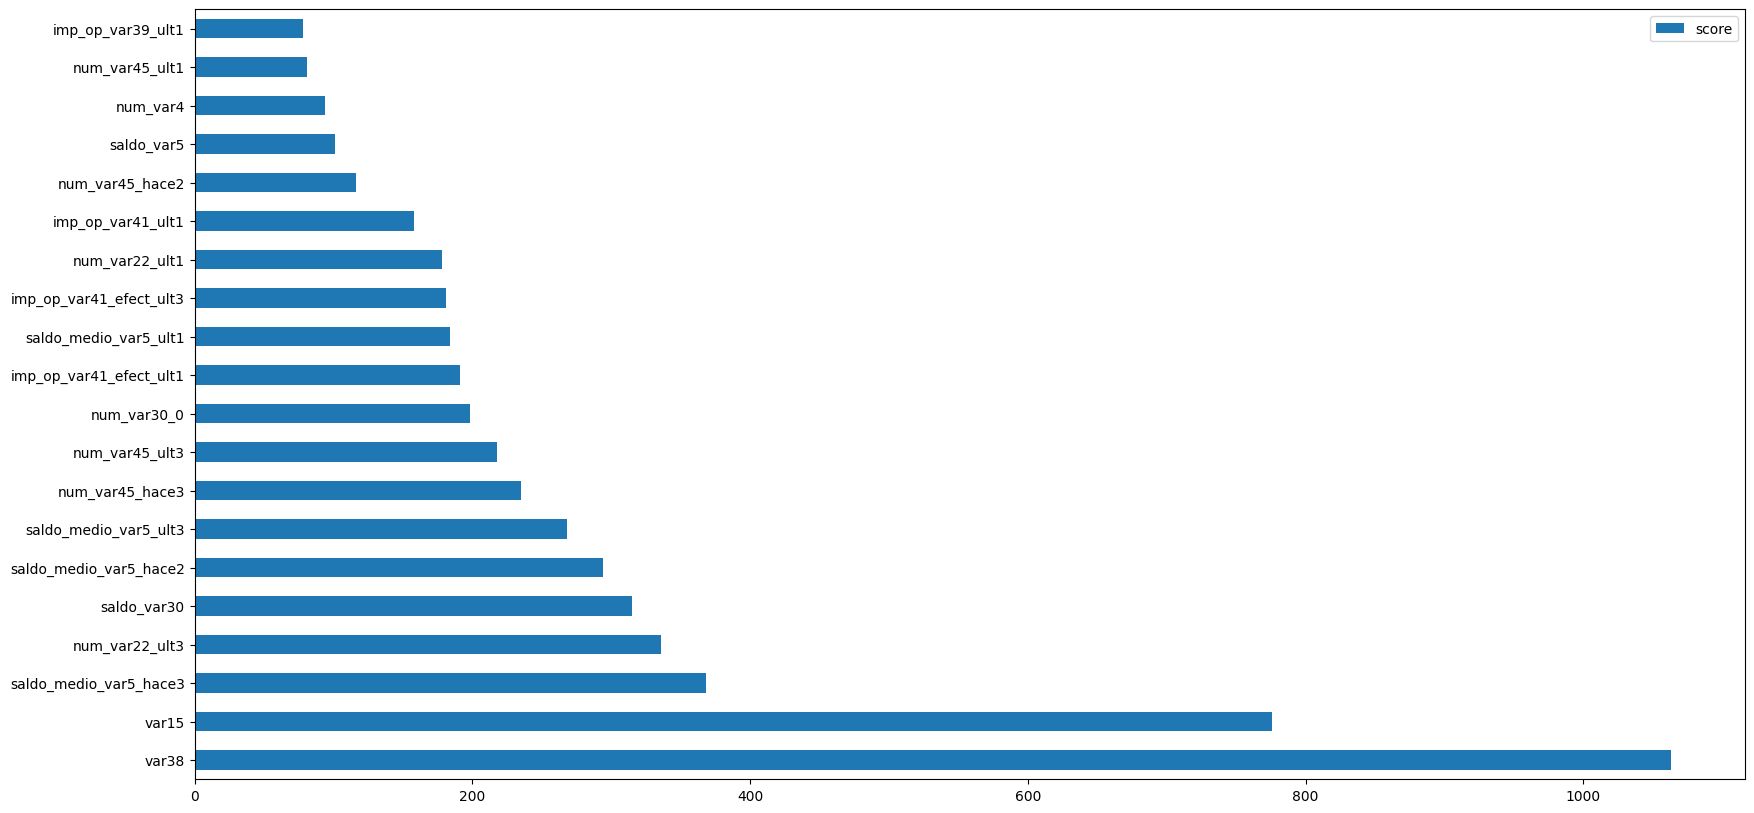

In [46]:
#XGBOOST variáveis mais significativas
xgboost_clf = xgb.XGBClassifier(scale_pos_weight=24.28,eta= 0.01,min_child_weight= 0,subsample= 1,seed=42)
xgboost_clf.fit(X_train, y_train)
feature_important = xgboost_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

O modelo otimizado que apresentou maior lucro foi o do XGBOOST.